In [1]:
import matplotlib
matplotlib.use("Agg")
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate, add, LeakyReLU, ZeroPadding2D, Add, GaussianDropout, merge, AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import RMSprop, adam
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.initializers import glorot_uniform, he_normal, zeros
import tensorflow as tf
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras import regularizers

Using TensorFlow backend.


In [2]:
save_dir = os.path.join(os.getcwd(), 'FACE_Model_SqueezeNet_v1')
save_dir_pb = os.path.join(os.getcwd(), 'FACE_Model_SqueezeNet_v1')
model_name = 'FACE_model_squeeze'
print(save_dir)

/content/FACE_Model_SqueezeNet_v1


In [3]:
## mount to remote drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
## get current path
os.getcwd()

'/content'

In [5]:
#!ls "/content/drive/My Drive"
#!cd "/content/drive/My Drive/gender_dataset_face"
!ls "/content/drive/My Drive/gender_dataset_face/man"

face_0.jpg     face_1272.jpg  face_1522.jpg  face_414.jpg  face_699.jpg
face_1000.jpg  face_1273.jpg  face_1523.jpg  face_415.jpg  face_69.jpg
face_1001.jpg  face_1274.jpg  face_1524.jpg  face_417.jpg  face_6.jpg
face_1003.jpg  face_1275.jpg  face_1525.jpg  face_419.jpg  face_700.jpg
face_1004.jpg  face_1276.jpg  face_1527.jpg  face_41.jpg   face_701.jpg
face_1005.jpg  face_1278.jpg  face_1528.jpg  face_421.jpg  face_702.jpg
face_1006.jpg  face_1279.jpg  face_152.jpg   face_423.jpg  face_703.jpg
face_1007.jpg  face_127.jpg   face_153.jpg   face_425.jpg  face_705.jpg
face_1010.jpg  face_1280.jpg  face_154.jpg   face_426.jpg  face_706.jpg
face_1011.jpg  face_1282.jpg  face_156.jpg   face_427.jpg  face_707.jpg
face_1012.jpg  face_1283.jpg  face_157.jpg   face_428.jpg  face_709.jpg
face_1014.jpg  face_1284.jpg  face_158.jpg   face_429.jpg  face_710.jpg
face_1016.jpg  face_1285.jpg  face_159.jpg   face_42.jpg   face_711.jpg
face_1018.jpg  face_1287.jpg  face_160.jpg   face_431.jpg  face_712

In [0]:
image_files = [f for f in glob.glob("/content/drive/My Drive/gender_dataset_face/**/*", recursive=True) if not os.path.isdir(f)] 
random.seed(42)
random.shuffle(image_files)

In [0]:
data = []
labels = []

img_dims = (96,96,3)

# create groud-truth label from the image path
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label])

In [0]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [0]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

##Model creation

In [0]:
def input_layers(y, conv_layers, kernel_reg, kernel_size=3):
  x = BatchNormalization()(y)

  x = Conv2D(conv_layers, 
             kernel_size=(kernel_size,kernel_size), 
             kernel_regularizer=regularizers.l2(kernel_reg),
             padding = "same",
             use_bias=True,
             bias_initializer=zeros(),
             kernel_initializer=he_normal(seed=0))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
    
  return x


In [0]:
def squeeze_A(y, conv_layers, kernel_reg, drop_rate):
  short_cut = y
  
  conv_by_pass = Conv2D(conv_layers, 
                        kernel_size=(1,1), 
                        kernel_initializer=he_normal(seed=0),
                        use_bias = True,
                        bias_initializer=zeros(),
                        kernel_regularizer=regularizers.l2(kernel_reg),
                        padding="same"
                       )(short_cut)
  #####squeeze structure
  ##expand
  conv_expand = Conv2D(conv_layers, 
                        kernel_size=(1,1), 
                        kernel_initializer=he_normal(seed=0),
                        use_bias = True,
                        bias_initializer=zeros(),
                        kernel_regularizer=regularizers.l2(kernel_reg),
                        padding="same"
                       )(y)
  ##squeeze 1
  batch_norm = BatchNormalization()(conv_expand)
  act = Activation("relu")(batch_norm)
  conv_squeeze_1 = Conv2D(int(conv_layers / 2), 
                        kernel_size=(1,1), 
                        kernel_initializer=he_normal(seed=0),
                        use_bias = True,
                        bias_initializer=zeros(),
                        kernel_regularizer=regularizers.l2(kernel_reg),
                        padding="same"
                       )(act)
  drop_out_1 = Dropout(drop_rate)(conv_squeeze_1)
  batch_norm_1 = BatchNormalization()(drop_out_1)
  act_1 = Activation("relu")(batch_norm_1)
  
  ##squeeze_2
  conv_squeeze_2 = Conv2D(int(conv_layers / 2), 
                        kernel_size=(3,3), 
                        kernel_initializer=he_normal(seed=0),
                        use_bias = True,
                        bias_initializer=zeros(),
                        kernel_regularizer=regularizers.l2(kernel_reg),
                        padding="same"
                       )(act)
  drop_out_2 = Dropout(drop_rate)(conv_squeeze_2)
  batch_norm_2 = BatchNormalization()(drop_out_2)
  act_2 = Activation("relu")(batch_norm_2)
  
  ## concatenate
  
  concat = concatenate([act_1, act_2], axis=3)
  
  ##summing
  
  sum_x = add([conv_by_pass, concat])
  x = BatchNormalization()(sum_x)
  x = Activation("relu")(x)
  
  return x
  

In [0]:
def squeeze_B(y, conv_layers, kernel_reg, drop_rate):
  
  short_cut = y
  
  #####squeeze structure
  ##expand
  conv_expand = Conv2D(conv_layers, 
                        kernel_size=(1,1), 
                        kernel_initializer=he_normal(seed=0),
                        use_bias = True,
                        bias_initializer=zeros(),
                        kernel_regularizer=regularizers.l2(kernel_reg),
                        padding="same"
                       )(y)
  ##squeeze 1
  batch_norm = BatchNormalization()(conv_expand)
  act = Activation("relu")(batch_norm)
  conv_squeeze_1 = Conv2D(int(conv_layers / 2), 
                        kernel_size=(1,1), 
                        kernel_initializer=he_normal(seed=0),
                        use_bias = True,
                        bias_initializer=zeros(),
                        kernel_regularizer=regularizers.l2(kernel_reg),
                        padding="same"
                       )(act)
  drop_out_1 = Dropout(drop_rate)(conv_squeeze_1)
  batch_norm_1 = BatchNormalization()(drop_out_1)
  act_1 = Activation("relu")(batch_norm_1)
  
  ##squeeze_2
  conv_squeeze_2 = Conv2D(int(conv_layers / 2), 
                        kernel_size=(3,3), 
                        kernel_initializer=he_normal(seed=0),
                        use_bias = True,
                        bias_initializer=zeros(),
                        kernel_regularizer=regularizers.l2(kernel_reg),
                        padding="same"
                       )(act)
  drop_out_2 = Dropout(drop_rate)(conv_squeeze_2)
  batch_norm_2 = BatchNormalization()(drop_out_2)
  act_2 = Activation("relu")(batch_norm_2)
  
  ## concatenate
  
  concat = concatenate([act_1, act_2], axis=3)
  
  ##summing
  
  sum_x = add([conv_expand, short_cut])
  x = BatchNormalization()(sum_x)
  x = Activation("relu")(x)

  
  return x

In [0]:
def model_create(inp_shape,num_classes):
  """
  shape_input - input shape of training data
  num_classes - number of outputs
  """
  
  shape = inp_shape
  shape =np.array(shape).astype("int32")
  
  input_layer = Input(shape=shape)
  
  x = input_layers(input_layer, conv_layers=96, kernel_reg=0.0005, kernel_size=3)
  #first train
  x = squeeze_A(x, conv_layers=128, kernel_reg=0.0002, drop_rate=0.35)
  x = squeeze_B(x, conv_layers=128, kernel_reg=0.0002, drop_rate=0.35)
  x = squeeze_A(x, conv_layers=256, kernel_reg=0.0002, drop_rate=0.35)
  x = MaxPooling2D(pool_size=(2,2))(x)
  #second train
  x = squeeze_B(x, conv_layers=256, kernel_reg=0.0002, drop_rate=0.35)
  x = squeeze_A(x, conv_layers=384, kernel_reg=0.0002, drop_rate=0.35)
  x = squeeze_B(x, conv_layers=384, kernel_reg=0.0002, drop_rate=0.35)
  x = squeeze_A(x, conv_layers=384, kernel_reg=0.0002, drop_rate=0.35)
  x = MaxPooling2D(pool_size=(2,2))(x)
  #third size
  x = squeeze_B(x, conv_layers=384, kernel_reg=0.0001, drop_rate=0.5)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = AveragePooling2D()(x)
  x = Flatten()(x)
  x = Dropout(0.5)(x)
  output = Dense(num_classes, activation="softmax", use_bias=True, kernel_initializer=he_normal(seed=0), bias_initializer=zeros(),kernel_regularizer = regularizers.l2(0.0001))(x)
  
  model = Model([input_layer], output)
  plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
 
  return model

In [0]:
model = model_create(img_dims,2)

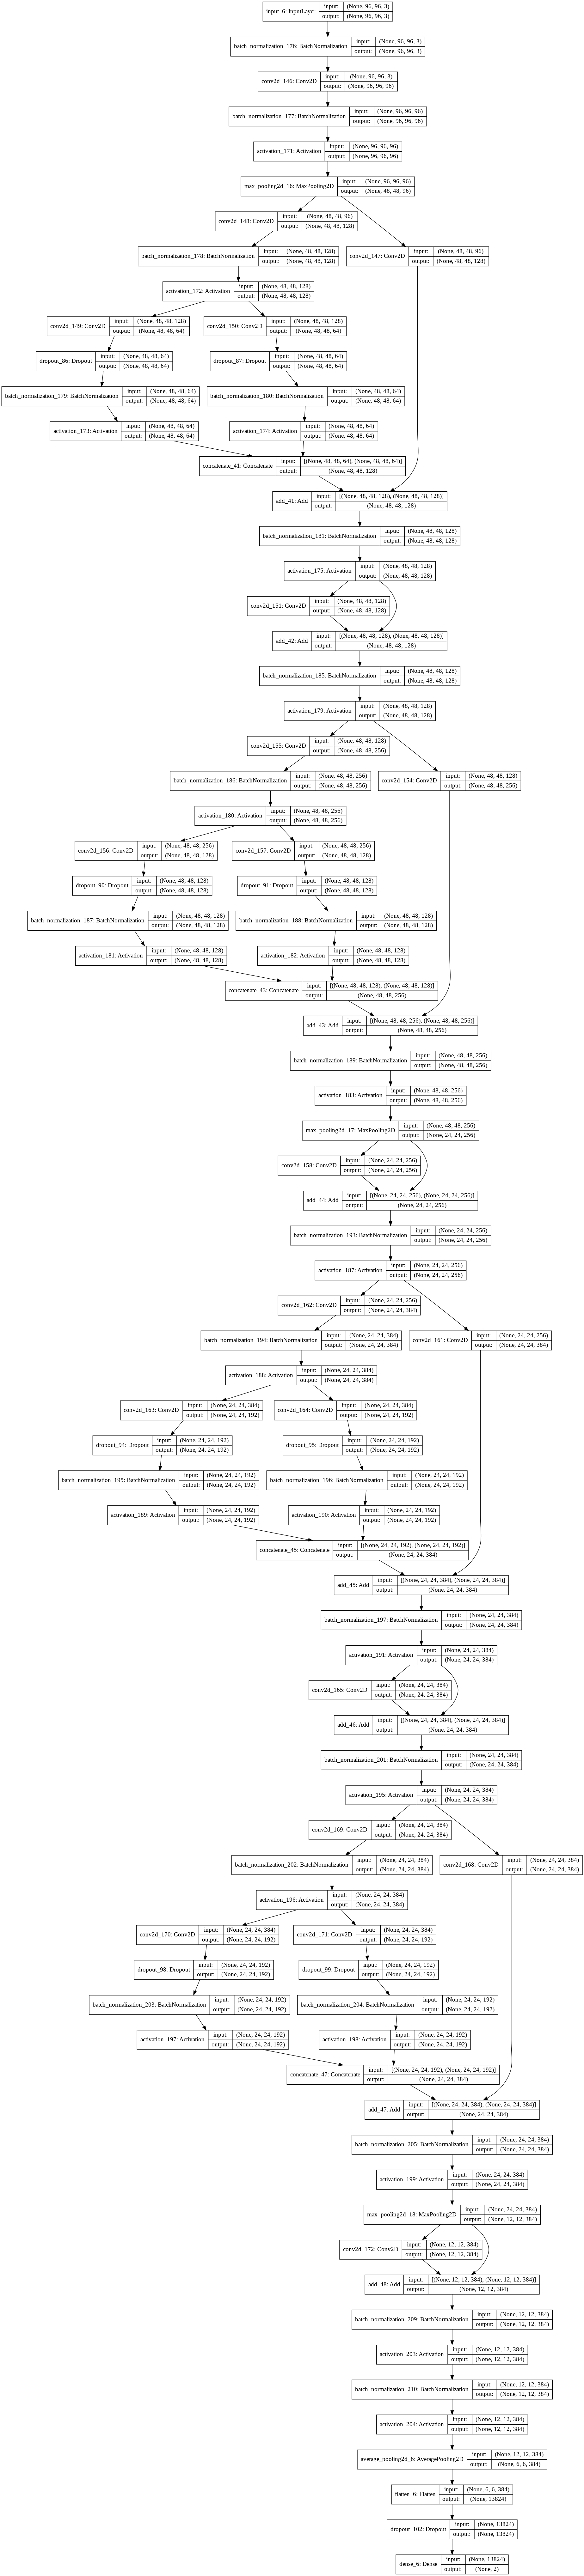

In [48]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [0]:
## utils creation

from keras.callbacks import Callback
class WeightsSaver(Callback):
  def __init__(self, N):
    self.N = N
    self.epoch = 0

  def on_epoch_end(self, epoch, logs={}):
    if self.epoch % self.N == 0:
      name = 'weights%08d.h5' % self.epoch
      self.model.save_weights(name)
    self.epoch += 1
    
    
lr_schedule = [10,15,20,25,30,90] # epoch_step
def schedule(epoch_idx):
    if (epoch_idx + 1) < lr_schedule[0]:
        return 0.00015
    elif (epoch_idx + 1) < lr_schedule[1]:
        return 0.00015*0.6 # lr_decay_ratio = 0.2
    elif (epoch_idx + 1) < lr_schedule[2]:
        return 0.00015*0.4
    elif (epoch_idx + 1) < lr_schedule[3]:
        return 0.00015*0.3
    elif (epoch_idx + 1) < lr_schedule[4]:
        return 0.00015*0.2
    elif (epoch_idx + 1) < lr_schedule[3]:
        return 0.00015*0.12  
    return 0.0001*0.08

weigh_decay = regularizers.l2(0.0005)

params = {
    "learning_rate" : 0.001,
    "log_dir" : "/content/saved_models/logs",
    "epochs" : 15,
    "batch_size" : 128
    
}

In [50]:
##compile model
tensorboard = TensorBoard(log_dir=params["log_dir"], histogram_freq=0, write_graph=True, write_images=False)

#opt = RMSprop(lr=params["learning_rate"], decay=params["decay"])
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy', 'categorical_accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_176 (BatchN (None, 96, 96, 3)    12          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_146 (Conv2D)             (None, 96, 96, 96)   2688        batch_normalization_176[0][0]    
__________________________________________________________________________________________________
batch_normalization_177 (BatchN (None, 96, 96, 96)   384         conv2d_146[0][0]                 
____________________________________________________________________________________________

In [51]:
batch_size =128

history = model.fit_generator(aug.flow(trainX, trainY,
                                     batch_size=batch_size), validation_data=(testX,testY), 
                    verbose=1,
                    steps_per_epoch=len(trainX) // batch_size,
                    epochs=params["epochs"], 
                    callbacks=[tensorboard, WeightsSaver(5), LearningRateScheduler(schedule=schedule)], 
                    shuffle=True)

Epoch 1/15
14/14 [==============================] - 35s 3s/step - loss: 2.7086 - acc: 0.5577 - categorical_accuracy: 0.5577 - val_loss: 2.4771 - val_acc: 0.6688 - val_categorical_accuracy: 0.6688
Epoch 2/15
14/14 [==============================] - 24s 2s/step - loss: 2.6190 - acc: 0.6353 - categorical_accuracy: 0.6353 - val_loss: 2.4252 - val_acc: 0.7208 - val_categorical_accuracy: 0.7208
Epoch 3/15
14/14 [==============================] - 24s 2s/step - loss: 2.5094 - acc: 0.7018 - categorical_accuracy: 0.7018 - val_loss: 2.3595 - val_acc: 0.7706 - val_categorical_accuracy: 0.7706
Epoch 4/15
14/14 [==============================] - 24s 2s/step - loss: 2.4403 - acc: 0.7468 - categorical_accuracy: 0.7468 - val_loss: 2.3214 - val_acc: 0.7965 - val_categorical_accuracy: 0.7965
Epoch 5/15
14/14 [==============================] - 24s 2s/step - loss: 2.4346 - acc: 0.7524 - categorical_accuracy: 0.7524 - val_loss: 2.2967 - val_acc: 0.7965 - val_categorical_accuracy: 0.7965
Epoch 6/15
14/14 [==

In [0]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=None):
  """
  @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
  """
  from tensorflow.python.framework.graph_util import convert_variables_to_constants
  
  graph = session.graph
  with graph.as_default():
    freeze_var_names = list(set(v.op.name for v in tf.global_variables())
                            .difference(keep_var_names or []))
    output_names = output_names or []
    output_names += [v.op.name for v in tf.global_variables()]
    input_graph_def = graph.as_graph_def()
    
    if clear_devices:
      for node in input_graph_def.node:
        node.device = ""
    frozen_graph = convert_variables_to_constants(session, input_graph_def, output_names, freeze_var_names)
    
    return frozen_graph

In [53]:
frozen_graph = freeze_session(K.get_session(),
                             output_names=[out.op.name for out in model.outputs])
x = tf.train.write_graph(frozen_graph, save_dir_pb, "FACE_Model_SqueezeNet_v1", as_text=False)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 3965 variables.
INFO:tensorflow:Converted 3965 variables to const ops.


In [56]:
##download pb file
from google.colab import files
pb_file = files.download("/content/FACE_Model_SqueezeNet_v1/FACE_Model_SqueezeNet_v1")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 48074, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil